## Implementation of Channel Shuffle v1 and v2

Data Source Download: https://github.com/fastai/imagenette 160px option (unable to upload to GitHub)

I unpacked the data using 7zip to obtain the train and test folders. This dataset is a subset of the original images from the ImageNet dataset and consists of 10 classes. I chose to use this dataset because the CIFAR-10 dataset is too low resolution for ShuffleNet v1/v2 and there are no higher resolution CIFAR-10 datasets available from what I could find. The Imagenette dataset seemed to be an analagous dataset that could be used for similar purposes, however, the training sets are far smaller than those in CIFAR-10.

I have included the pre-trained models as Shufflev1 and Shufflev2 in the GitHub Repository so they can be loaded to verify that they do work.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import PIL
import pickle

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


Loading in the imagenette data. Here I am applying a few augmentations to the data such as flipping the image horizontally, random rotation up to 20 degrees, and resizing the image to be a square 160x160. Here is where you can change the path to point to the directory where you are storing the train/validation folders.

In [3]:
transform = transforms.Compose(
    [transforms.Resize((160,160)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform2 = transforms.Compose(
    [transforms.Resize((160,160)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                          
trainset = torchvision.datasets.ImageFolder(root=r"E:\Data Science\Imagenette\train",
                                             transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root=r'E:\Data Science\Imagenette\val',
                                       transform=transform2)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                          shuffle=False, num_workers=2)

classes = ('tench', 'English springer', 'cassette player', 'chain saw',
            'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute')

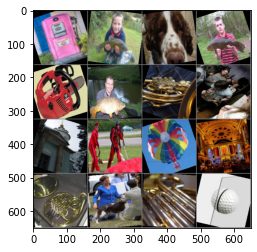

gas pump tench English springer tench chain saw tench French horn French horn church parachute parachute church French horn English springer French horn golf ball


In [4]:
imgset_loader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(imgset_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images, nrow=4))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

##############################################################################################################
## ShuffleNet Unit
##############################################################################################################

In [5]:
class ShuffleUnit(nn.Module):
    def __init__(self, in_ch, out_ch, groups=3, downsample=False):
        super(ShuffleUnit, self).__init__()
        
        self.downsample = downsample
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.bottleneck_ch = out_ch//4
        self.groups = groups
        #bottleneck ratio of 1:2 used in the paper
        
        self.in_conv1x1 = nn.Conv2d(in_channels = self.in_ch, out_channels = self.bottleneck_ch, kernel_size = 1, bias=False, groups=self.groups)
        self.Relu = nn.ReLU()

        if downsample:
            #branch
            self.branch1 = nn.Sequential(
                    nn.BatchNorm2d(self.bottleneck_ch),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels = self.bottleneck_ch, out_channels = self.bottleneck_ch, kernel_size = 3, stride = 2, padding = 1, groups = self.bottleneck_ch),
                    nn.BatchNorm2d(self.bottleneck_ch),
                    nn.Conv2d(in_channels = self.bottleneck_ch, out_channels = self.out_ch, kernel_size = 1, bias=False, groups=self.groups),
                    nn.BatchNorm2d(self.out_ch),
                    nn.ReLU(inplace=True)
            )
            
            self.resblock = nn.AvgPool2d(kernel_size = 3, stride = 2, padding=1)
        
        
        else:
            self.branch1 = nn.Sequential(
                nn.BatchNorm2d(self.bottleneck_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels = self.bottleneck_ch, out_channels = self.bottleneck_ch, kernel_size = 3, padding = 1, groups = self.bottleneck_ch),
                nn.BatchNorm2d(self.bottleneck_ch),
                nn.Conv2d(in_channels = self.bottleneck_ch, out_channels = self.out_ch, kernel_size = 1, bias=False, groups=self.groups),
                nn.BatchNorm2d(self.out_ch),
                nn.ReLU(inplace=True)
            )

               
    def channel_shuffle(self, x):
        batch, channels, pixelsh, pixelsw = x.size()
        
        #as mentioned in the paper: reshape into (g,n) outputs, transpose, and "flatten" back
        x = x.reshape(batch, self.groups, self.bottleneck_ch//self.groups, pixelsw, pixelsh).permute(0,2,1,3,4)
        x = x.reshape(batch, self.bottleneck_ch, pixelsw,pixelsh)
    
        return x
        
        
    def forward(self, x):
        
        if self.downsample:
            res = self.resblock(x)
            x = self.in_conv1x1(x)
            x = self.channel_shuffle(x)
            x = self.branch1(x)
            x = torch.cat((res,x), dim=1)
            x = self.Relu(x)
           
        else:
            res = x
            x=self.in_conv1x1(x)
            x= self.channel_shuffle(x)
            x = self.branch1(x)
            x = torch.add(res, x)
        return x

class CNN_Shuffle(nn.Module):
    def __init__(self, groups = 3):
        super(CNN_Shuffle, self).__init__()
        
        self.groups = groups
        
        if self.groups == 1:
            self.output_channels = [24, 144, 288, 576]
        elif self.groups == 2:
            self.output_channels = [24, 200, 400, 800]
        elif self.groups == 3:
            self.output_channels = [24, 240, 480, 960]
        elif self.groups == 4:
            self.output_channels = [24, 272, 544, 1088]
        elif self.groups == 8:
            self.output_channels = [24, 384, 768, 1536]
        else:
            raise('invalid group #')
        
       
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 24, kernel_size = 3, stride = 2, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.globalpool = nn.AvgPool2d(kernel_size = 5)
        
        self.stage2 = self.make_stage(self.output_channels[0], self.output_channels[1], reps=3)
        self.stage3 = self.make_stage(self.output_channels[1], self.output_channels[2], reps=7)
        self.stage4 = self.make_stage(self.output_channels[2], self.output_channels[3], reps=3)
        
        self.fc = nn.Linear(self.output_channels[3]*1*1, 10)
      
       
    def make_stage(self, in_channels, out_channels, reps, groups=3):
        modules = []
        modules.append(ShuffleUnit(in_channels, out_channels-in_channels, downsample=True))
        for i in range(reps):
            modules.append(ShuffleUnit(out_channels, out_channels))
        
        sequence = nn.Sequential(*modules)
        return sequence
        
    def forward(self, x):  
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.globalpool(x)
        x = x.view(-1,self.output_channels[3] )
        x = self.fc(x)
        
        return x
    
#Instantiate the Net
net_shuffle = CNN_Shuffle().to(device)

A little refresh on what's going on here:

- We feed our data into a 3x3 convolution with stride 2 and always output 24 channels
- Next we max pool with kernel 3x3 and stride two which further downsamples the data
- We build "stage 2" which includes a 1x1 group convolution, the channel shuffle operation, then 3x3 DW separable convolution, and finally another 1x1 group convolution to expand out the feature maps. This is concatenated with the residual connection with contains 3x3 average pooling with stride 2. We repeat this stage 3 more times, however, we do not downsample and add the output from this branch with the residual connection which is simply the identity.
- Stages 3 and 4 are built in a similar fashion with stage 3 containing 7 repeats of the non downsampling units and stage 4 being identical to stage 2 with the exception of the final output of feature maps.
- We global pool the output from stage 4 and feed it into a fully connected layer to reduce to our class size

Group numbers can be changed to which will in turn change the number of feature map outputs at each stage. Less groups leads to more complexity (in FLOPS) while more groups leads to less complexity, however, the neighborgood of the number of parameters for each group is not substantially different from one another.

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_shuffle.parameters(), lr=.01, momentum=0.9)

In [7]:
import time
tic = time.clock()
training_errors = []
validation_accuracy = []
validation_errors = []
correct = 0
total = 0


for epoch in range(80):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_shuffle(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += outputs.shape[0] * loss.item()
        
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    training_errors.append(epoch_loss)        
        
    if epoch % 50 == 0:
        print(epoch)
        
save = torch.save(net_shuffle, './Shufflev1')
        
print('Finished Training')
toc = time.clock()
print((toc - tic)/60, "Minutes")

0
50
Finished Training
22.419478243333334 Minutes


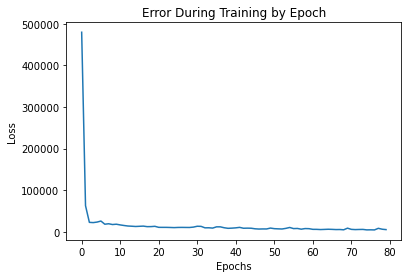

In [8]:
plt.plot(training_errors)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Error During Training by Epoch");

In [9]:
net_shuffle = torch.load('./Shufflev1')

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_shuffle(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 20 %


As we can see this network does not perform quite well. For training on a home GPU I had to make some modifications to what the paper was using, one being using Imagenette which contains 10 classes from the ImageNet dataset. I also downsized the images to 160x160 for better training. Perhaps leaving the images at their original size would increase performance, but my purpose was to get some results and demonstrate that this implementation of ShuffleNet would work.

##############################################################################################################
## ShuffleNet Unit V2
##############################################################################################################

In [11]:
class ShuffleUnitv2(nn.Module):
    def __init__(self, in_ch, out_ch, downsample=False):
        super(ShuffleUnitv2, self).__init__()
        
        self.downsample = downsample
        self.in_ch = in_ch
        #bottleneck ratio of 1:2 used in the paper
        
        if downsample:
            self.out_ch = int(out_ch//2)    
            #branch
            self.branch1 = nn.Sequential(
                    nn.Conv2d(in_channels = self.in_ch, out_channels = self.out_ch, kernel_size = 1, bias=False),
                    nn.BatchNorm2d(self.out_ch),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels = self.out_ch, out_channels = self.out_ch, kernel_size = 3, stride = 2, padding = 1, groups = self.out_ch),
                    nn.BatchNorm2d(self.out_ch),
                    nn.Conv2d(in_channels = self.out_ch, out_channels = self.out_ch, kernel_size = 1, bias=False),
                    nn.BatchNorm2d(self.out_ch),
                    nn.ReLU(inplace=True)
            )
            
            self.resblock = nn.Sequential(
                        nn.Conv2d(in_channels = self.in_ch, out_channels = self.in_ch, kernel_size = 3, stride=2, padding = 1, groups = self.in_ch),
                        nn.BatchNorm2d(self.in_ch),
                        nn.Conv2d(in_channels = self.in_ch, out_channels = self.out_ch, kernel_size = 1, bias=False),
                        nn.BatchNorm2d(self.out_ch),
                        nn.ReLU(inplace=True)
            )
        
        
        else:
            self.out_ch = int(out_ch//2)
            self.branch1 = nn.Sequential(
                    nn.Conv2d(in_channels = self.out_ch, out_channels = self.out_ch, kernel_size = 1, bias=False),
                    nn.BatchNorm2d(self.out_ch),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels = self.out_ch, out_channels = self.out_ch, kernel_size = 3, padding = 1, groups = self.out_ch),
                    nn.BatchNorm2d(self.out_ch),
                    nn.Conv2d(in_channels = self.out_ch, out_channels = self.out_ch, kernel_size = 1, bias=False),
                    nn.BatchNorm2d(self.out_ch),
                    nn.ReLU(inplace=True)
            )

               
    def channel_shuffle(self, x):
        batch, channels, pixelsh, pixelsw = x.size()
    
        #as mentioned in the paper: reshape into (g,n) outputs, transpose, and "flatten" back
        x = x.reshape(batch, 2, channels//2, pixelsh, pixelsw).permute(0,2,1,3,4)
        x = x.reshape(batch, channels, pixelsh, pixelsw)
    
        return x
        
        
    def forward(self, x):
        
        if self.downsample:
            res = self.resblock(x)
            x = self.branch1(x)
            x = torch.cat((res, x), dim=1)
            
        else:
            res, x = torch.chunk(x, 2, dim=1)
            x = self.branch1(x)
            x = torch.cat((res, x), dim=1)
            
        x = self.channel_shuffle(x)
        return x

class CNN_Shufflev2(nn.Module):
    def __init__(self, complexity = 1, use_stride = False):
        super(CNN_Shufflev2, self).__init__()
        
        self.complexity = complexity
        self.use_stride = use_stride
        
        if self.complexity == 0.5:
            self.output_channels = [24, 48, 96, 192]
        elif self.complexity == 1:
            self.output_channels = [24, 116, 232, 464]
        elif self.complexity == 1.5:
            self.output_channels = [24, 176, 352, 488]
        elif self.complexity == 2:
            self.output_channels = [24, 244, 488, 976]
        else:
            raise('invalid complexity #')
        
       
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 24, kernel_size = 3, stride = 2, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.globalpool = nn.AvgPool2d(kernel_size = 5)
        
        self.stage2 = self.make_stage(self.output_channels[0], self.output_channels[1], reps=3)
        self.stage3 = self.make_stage(self.output_channels[1], self.output_channels[2], reps=7)
        self.stage4 = self.make_stage(self.output_channels[2], self.output_channels[3], reps=3)
        
        self.conv5 = nn.Conv2d(in_channels = self.output_channels[3], out_channels = 1024 ,kernel_size = 1, bias=False)
        self.fc = nn.Linear(1024, 10)
      
       
    def make_stage(self, in_channels, out_channels, reps):
        modules = []
        modules.append(ShuffleUnitv2(in_channels, out_channels, downsample=True))
        for i in range(reps):
            modules.append(ShuffleUnitv2(out_channels, out_channels))
        
        sequence = nn.Sequential(*modules)
        return sequence
        
    def forward(self, x):  
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.conv5(x)
        x = self.globalpool(x)
        x = x.view(-1,1024) #flatten
        x = self.fc(x)
        
        return x
    
#Instantiate the Net
net_shufflev2 = CNN_Shufflev2().to(device)

A summary of the code above:
- Overall the macro structure of the network is very similar to ShuffleNet v1
- First two layers are the same, a 3x3 convolutional layer with stride of 2 and a 3x3 maxpool with stride 2 that always output 24 channels.
- ShuffleNet v2 Unit downsamples in the first part of each stage using a 3x3 depthwise convolution with stride 2 and a 1x1 convolution in the residual connection. The other branch uses a 1x1 convolution (not groupwise), a 3x3 depthwise convolution with stride 2, and a 1x1 convolution again. The output from this branch and residual connection are then concatenated along the channel dimension. Lastly, we perform a channel shuffle.
- The next block that is repeated uses a channel split operation which splits the tensor into two tensors with equal channels. The residual connection is now the identity of one of the split tensors. The other branch is equivalent to that above except the 3x3 depthwise convolution uses stride 1. The output from each are then concatenated along the channel dimension. Lastly, we perform a channel shuffle.
- The number of stages/repitions are kept the same but now we include a convolution that outputs 1024 channels, then we perform global pooling, and lastly a fully connected layer that outputs channels equal to the number of classes to be predicted.

0
50
Finished Training
20.894974528333332 Minutes


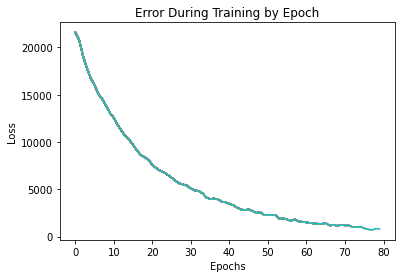

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_shufflev2.parameters(), lr=0.01, momentum=0.9)


import time
tic = time.clock()
training_errors2 = []
validation_accuracy2 = []
correct = 0
total = 0


for epoch in range(80):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_shufflev2(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += outputs.shape[0] * loss.item()
        
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    training_errors2.append(epoch_loss)
        
        
    if epoch % 50 == 0:
         print(epoch)
    
    plt.plot(training_errors2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Error During Training by Epoch");
        
save = torch.save(net_shufflev2, './Shufflev2')
        
print('Finished Training')
toc = time.clock()
print((toc - tic)/60, "Minutes")

In [13]:
net_shufflev2 = torch.load('./Shufflev2')

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_shufflev2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 20 %


While these networks did not produce the results I was expecting, they are able to work. Additional tuning would be needed given that I used a dataset and resolutions different from that in the paper. These models are very likely overfit as well as I did not include early stopping in order to save on computation time for my home GPU. Overall though, my goal of implementing these network architectures was successful but would still require some work to obtain competitive test accuracies.